In [1]:
!pip install 'powerlaw'

In [1]:
import bmll2 as b2
import random
import math
import pandas as pd
import numpy as np
from pandas import StringDtype

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogFormatterSciNotation

from statsmodels.sandbox.stats.runs import runstest_1samp 
import powerlaw
import itertools
import pylab
import scipy.stats
from scipy.optimize import curve_fit

import shutil
from pathlib import Path
import warnings

In [3]:
top40_tickers = [
    "ABG",  # ABSA
    "AGL",  # Anglo American
    "ANG",  # Anglogold Ashanti
    "ANH",  # AB InBev
    "APN",  # Aspen Pharmacare
    "BHG",  # BHP Group
    "BID",  # Bidcorp
    "BVT",  # Bidvest
    "BTI",  # British American Tobacco
    "CPI",  # Capitec
    "CLS",  # Clicks
    "DSY",  # Discovery  
    "EXX",  # Exxaro
    "FSR",  # FirstRand
    "GLN",  # Glencore
    "GFI",  # Gold Fields
    "GRT",  # Growthpoint
    "IMP",  # Impala Platinum
    "INL",  # Investec Ltd
    "INP",  # Investec PLC
    "MNP",  # Mondi
    "MRP",  # Mr Price
    "MTN",  # MTN Group
    "NPN",  # Naspers
    "NED",  # Nedbank
    "NRP",  # NEPI Rockcastle
    "OMU",  # Old Mutual
    "PRX",  # Prosus
    "RNI",  # Reinet Investments
    "REM",  # Remgro
    "RMH",  # RMB
    "SLM",  # Sanlam
    "SOL",  # Sasol
    "SHP",  # Shoprite
    "SBK",  # Standard Bank
    "VAL",  # Valterra platinum
    "VOD",  # Vodacom
    "WHL"   # Woolworths
]

In [4]:
%%time
files = b2.list_files(path = 'test_data')

files = [f for f in files if ('run_lengths' in f) or ('trade_signs' in f)]
for f in files:
    b2.get_file(f'test_data/{f}')

# takes about 3 minutes to load

CPU times: user 14.3 s, sys: 1.99 s, total: 16.3 s
Wall time: 3min 26s


In [5]:
%%time
yearly_run_lengths_2023 = {}
yearly_run_lengths_2024 = {}
yearly_run_lengths_2025 = {}

for ticker in top40_tickers:

    try:
        yearly_run_lengths_2023[ticker] = pd.read_csv(f'{ticker}_run_lengths_yearly_2023.csv')
    except FileNotFoundError:
        print (f'{ticker}_run_lengths_yearly_2023.csv not found')
        pass
        
    try:
        yearly_run_lengths_2024[ticker] = pd.read_csv(f'{ticker}_run_lengths_yearly_2024.csv')
    except FileNotFoundError:
        print (f'{ticker}_run_lengths_yearly_2024.csv not found')
        pass

    try:
        yearly_run_lengths_2025[ticker] = pd.read_csv(f'{ticker}_run_lengths_yearly_2025.csv')
    except FileNotFoundError:
        print (f'{ticker}_run_lengths_yearly_2025.csv not found')
        pass

half_yearly_run_lengths_2023 = {}
half_yearly_run_lengths_2024 = {}
half_yearly_run_lengths_2025 = {}

for ticker in top40_tickers:

    half_yearly_run_lengths_2023[ticker] = {}

    for half in ['H1', 'H2']:
        try:
            half_yearly_run_lengths_2023[ticker][half] = pd.read_csv(f'{ticker}_run_lengths_half_yearly_2023_{half}.csv')
        except FileNotFoundError: 
            print (f'{ticker}_run_lengths_half_yearly_2023_{half}.csv not found')
            pass

    if not half_yearly_run_lengths_2023[ticker]:
        del half_yearly_run_lengths_2023[ticker]

    half_yearly_run_lengths_2024[ticker] = {}

    for half in ['H1', 'H2']:
        try:
            half_yearly_run_lengths_2024[ticker][half] = pd.read_csv(f'{ticker}_run_lengths_half_yearly_2024_{half}.csv')
        except FileNotFoundError:
            print (f'{ticker}_run_lengths_half_yearly_2024_{half}.csv not found')
            pass

    if not half_yearly_run_lengths_2024[ticker]:
        del half_yearly_run_lengths_2024[ticker]

    half_yearly_run_lengths_2025[ticker] = {}

    for half in ['H1', 'H2']:
        try:
            half_yearly_run_lengths_2025[ticker][half] = pd.read_csv(f'{ticker}_run_lengths_half_yearly_2025_{half}.csv')
        except FileNotFoundError:
            print (f'{ticker}_run_lengths_half_yearly_2025_{half}.csv not found')
            pass

    if not half_yearly_run_lengths_2025[ticker]:
        del half_yearly_run_lengths_2025[ticker]

# takes about 2 seconds to load

RMH_run_lengths_yearly_2025.csv not found
APN_run_lengths_half_yearly_2023_H2.csv not found
DSY_run_lengths_half_yearly_2023_H2.csv not found
EXX_run_lengths_half_yearly_2023_H2.csv not found
RMH_run_lengths_half_yearly_2025_H1.csv not found
RMH_run_lengths_half_yearly_2025_H2.csv not found
CPU times: user 2.1 s, sys: 287 ms, total: 2.38 s
Wall time: 2.38 s


In [6]:
%%time
trade_signs_2023 = {}
trade_signs_2024 = {}
trade_signs_2025 = {}

for ticker in top40_tickers:

    try:
        trade_signs_2023[ticker] = pd.read_csv(f'{ticker}_trade_signs_2023.csv')
    except FileNotFoundError:
        print (f'{ticker}_trade_signs_2023.csv not found')
        pass
        
    try:
        trade_signs_2024[ticker] = pd.read_csv(f'{ticker}_trade_signs_2024.csv')
    except FileNotFoundError:
        print (f'{ticker}_trade_signs_2024.csv not found')
        pass

    try:
        trade_signs_2025[ticker] = pd.read_csv(f'{ticker}_trade_signs_2025.csv')
    except FileNotFoundError:
        print (f'{ticker}_trade_signs_2025.csv not found')
        pass

trade_signs_2023_half = {}
trade_signs_2024_half = {}
trade_signs_2025_half = {}

for ticker in top40_tickers:

    trade_signs_2023_half[ticker] = {}

    for half in ['H1', 'H2']:
        try:
            trade_signs_2023_half[ticker][half] = pd.read_csv(f'{ticker}_trade_signs_2023_{half}.csv')
        except FileNotFoundError: 
            print (f'{ticker}_trade_signs_2023_{half}.csv not found')
            pass

    if not trade_signs_2023_half[ticker]:
        del trade_signs_2023_half[ticker]

    trade_signs_2024_half[ticker] = {}

    for half in ['H1', 'H2']:
        try:
            trade_signs_2024_half[ticker][half] = pd.read_csv(f'{ticker}_trade_signs_2024_{half}.csv')
        except FileNotFoundError:
            print (f'{ticker}_trade_signs_2024_{half}.csv not found')
            pass

    if not trade_signs_2024_half[ticker]:
        del trade_signs_2024_half[ticker]

    trade_signs_2025_half[ticker] = {}

    for half in ['H1', 'H2']:
        try:
            trade_signs_2025_half[ticker][half] = pd.read_csv(f'{ticker}_trade_signs_2025_{half}.csv')
        except FileNotFoundError:
            print (f'{ticker}_trade_signs_2025_{half}.csv not found')
            pass

    if not trade_signs_2025_half[ticker]:
        del trade_signs_2025_half[ticker]

# takes about 12 seconds to load

CPU times: user 11.5 s, sys: 667 ms, total: 12.2 s
Wall time: 12.2 s


In [15]:
def sign_autocorrelation(signs, max_lag):
    """
    Computes the sample sign autocorrelation C(tau) for tau = 1,...,max_lag
    
    Parameters
    ----------
    signs : array-like
        Sequence of trade signs (+1 / -1)
    max_lag : int
        Maximum lag tau to compute
    
    Returns
    -------
    taus : ndarray
        Array of lag values
    C : ndarray
        Sample autocorrelation values
    """
    signs = np.asarray(signs)
    N = len(signs)

    taus = np.arange(1, max_lag + 1)
    C = np.empty(max_lag)

    for i, tau in enumerate(taus):
        C[i] = np.mean(signs[:-tau] * signs[tau:])

    return taus, C

In [34]:
def select_powerlaw_range(taus, C, min_points = 1000):

    mask = (C > 0) & (np.isfinite(C))
    taus = taus[mask]
    C   = C[mask]

    log_tau = np.log(taus)
    log_C   = np.log(C)

    best       = None
    best_score = -np.inf

    for i in range(len(taus) - min_points): # stops it from going to far so that we always have min_points in the window, specifically at the end 
        for j in range(i + min_points, len(taus)): # same reason but specifically at the begining
            x = log_tau[i:j] 
            y = log_C[i:j] 
            slope, intercept = np.polyfit(x, y, 1)
            y_hat = intercept + (slope * x)
            r2    = 1 - np.sum((y - y_hat) ** 2) / np.sum((y - y.mean()) ** 2)

            if r2 > best_score:
                best_score = r2
                best = (i, j, slope)
                
    return best 

def select_powerlaw_range_fast(taus, C, min_points = 10000):

    mask = (C > 0) & np.isfinite(C)
    taus, C = taus[mask], C[mask]

    log_tau = np.log(taus)
    log_C   = np.log(C)

    N = len(log_tau)

    # cumulative sums
    # x is the log taus
    # y is the log C
    Sx  = np.cumsum(log_tau)
    Sy  = np.cumsum(log_C)
    Sxx = np.cumsum(log_tau ** 2)
    Syy = np.cumsum(log_C ** 2)
    Sxy = np.cumsum(log_tau * log_C)

    best_r2 = -np.inf
    best_i  = None

    j = N  # fixed right endpoint (tail fit)

    for i in range(N - min_points):
        
        n = j - i

        # gonna be working backwards here. We already precomputed the cumulative sum of the entire series we just need to subtract
        # the part thats no longer in it. It starts off on the largest window and makes it smaller each time. With this method we fix
        # the left endpoint of the window so that we only need to do a O(N) search and not a O(N^2) search. 
        sum_x  = Sx[j - 1]  - (Sx[i - 1]  if i > 0 else 0)
        sum_y  = Sy[j - 1]  - (Sy[i - 1]  if i > 0 else 0)
        sum_xx = Sxx[j - 1] - (Sxx[i - 1] if i > 0 else 0)
        sum_yy = Syy[j - 1] - (Syy[i - 1] if i > 0 else 0)
        sum_xy = Sxy[j - 1] - (Sxy[i - 1] if i > 0 else 0)

        denom = n * sum_xx - sum_x ** 2
        if denom == 0:
            continue

        slope = ((n * sum_xy) - (sum_x * sum_y)) / denom
        intercept = (sum_y - (slope * sum_x)) / n

        ss_tot = sum_yy - (sum_y ** 2)/n
        ss_res = sum_yy + (slope ** 2) * sum_xx + (n * intercept ** 2) - (2 * slope * sum_xy) - (2 * intercept * sum_y) + (2 * slope * intercept * sum_x)

        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else -np.inf

        if r2 > best_r2:
            best_r2 = r2
            best_i  = i
            best_slope = slope

    return best_i, N - 1, best_slope

    

In [17]:
def log_bin(taus, C, nbins = 10):
    
    df   = pd.DataFrame({'tau' : taus, 'C' : C})
    bins = np.logspace(np.log10(df['tau'].min()), np.log10(df['tau'].max()), nbins)

    df['bin'] = pd.cut(df['tau'], bins = bins)

    # y-values: arithmetic mean
    C_smooth = df.groupby('bin', observed = True)['C'].mean()

    # x-values: geometric mean
    taus_smooth = df.groupby('bin', observed = True)['tau'].apply(lambda x: np.exp(np.mean(np.log(x))))

    return taus_smooth.values, C_smooth.values


In [75]:
def powerlaw_fit(tau, C_0, gamma):
    
    return C_0 * (tau ** (- gamma))
    

In [139]:
def estimate_gamma_loglog(taus, C):

    x = np.log(taus)
    y = np.log(C)

    slope, intercept = np.polyfit(x, y, 1)
    gamma = -slope
    C_0 = np.exp(intercept)

    return C_0, gamma

In [146]:
def estimate_gamma(taus, C, min_points, nbins):

    mask = (C > 0) & (np.isfinite(C))
    taus = taus[mask]
    C    = C[mask]
    
    i, j, slope     = select_powerlaw_range_fast(taus, C, min_points)
    gamma_nlls_init = -1 * slope

    tau_min = taus[i]
    tau_max = taus[j]

    mask_fit = (taus >= tau_min) & (taus <= tau_max) & (np.isfinite(C))
    taus     = taus[mask_fit]
    C        = C[mask_fit]
    
    #taus_smooth, C_smooth = log_bin(taus, C, nbins = nbins)
    
    #C_0_init = C_smooth[0] if len(C_smooth) > 0 else 1.0
    #popt, pcov      = curve_fit(powerlaw_fit, taus_smooth, C_smooth, p0 = (C_0_init, gamma_nlls_init), maxfev = 10000) #taus[i:j] C[i:j] C[i]
    #C_0, gamma_nlls = popt

    C_0_init        = C[0] if len(C) > 0 else 1.0
    C_0, gamma_nlls = estimate_gamma_loglog(taus, C)

    return {'C_0' : C_0, 'gamma_nlls' : gamma_nlls}#, 'taus_smooth' : taus_smooth, 'C_smoth' : C_smooth}
    

In [144]:
def estimate_alpha(run_lengths):
    
    fit = powerlaw.Fit(run_lengths, discrete = True)
    
    # The powerlaw package gives alpha for CCDF P_>(L) ~ L^(-alpha)
    # For PDF P(L) ~ L^(-alpha-1), we have the same alpha
    alpha = fit.alpha - 1  # Adjust for PDF vs CCDF convention
    xmin  = fit.xmin
    
    return alpha, xmin
    

In [ ]:
%%time
results = []

for year, L_dict, trade_dict in [
    (2023, yearly_run_lengths_2023, trade_signs_2023),
    (2024, yearly_run_lengths_2024, trade_signs_2024),
    (2025, yearly_run_lengths_2025, trade_signs_2025),
]:
    print(f'Processing year: {year}')
    for ticker in top40_tickers:
        print(f'{ticker}')
        try:
            # Try to get the trade signs and run lengths
            signs = trade_dict[ticker]
            L     = L_dict[ticker]['L']

            # Calculate autocorrelation and gamma
            taus, C = sign_autocorrelation(signs, max_lag = 10000)
            out     = estimate_gamma(taus, C, min_points = 1000, nbins = 10)

            # Estimate alpha
            alpha, xmin = estimate_alpha(L)

            # Append results
            results.append({'year' : year, 'ticker' : ticker, 'xmin' : xmin, 'alpha' : alpha, 'gamma_nlls' : out['gamma_nlls']})

        except KeyError as e:
            print(f'Warning: missing data for {ticker} in {year}, skipping... ({e})')
        except Exception as e:
            print(f'Warning: error processing {ticker} in {year}, skipping... ({e})')

alpha_gamma_df = pd.DataFrame(results)

alpha_gamma_df.to_csv('alpha_gamma_df.csv', index = False)
b2.put_file('alpha_gamma_df.csv', 'test_data')

#for year, L_dict, trade_dict in [
#    (2023, yearly_run_lengths_2023, trade_signs_2023),
#    (2024, yearly_run_lengths_2024, trade_signs_2024),
#    (2025, yearly_run_lengths_2025, trade_signs_2025),
#]:
#    print(year)
#    for ticker in top40_tickers:
        
#        print(ticker)
#        signs   = trade_dict[ticker]
#        taus, C = sign_autocorrelation(signs, max_lag = 10000)
#        out     = estimate_gamma(taus, C, min_points = 1000, nbins = 10)

#        L           = L_dict[ticker]['L']
#        alpha, xmin = estimate_alpha(L)

#        results.append({'year' : year, 'ticker' : ticker, 'xmin' : xmin, 'alpha' : alpha, 'gamma_nlls' : out['gamma_nlls']})

#alpha_gamma_df = pd.DataFrame(results)

#alpha_gamma_df.to_csv('alpha_gamma_df.csv', index = False)
#b2.put_file('alpha_gamma_df.csv', 'test_data')

In [ ]:
%%time
results = []

for year, L_dict, trade_dict in [
    (2023, half_yearly_run_lengths_2023, trade_signs_2023_half),
    (2024, half_yearly_run_lengths_2024, trade_signs_2024_half),
    (2025, half_yearly_run_lengths_2025, trade_signs_2025_half),
]:
    print(f'Processing year: {year}')
    
    for half in ['H1', 'H2']:
        print(f'Half: {half}')
        
        for ticker in top40_tickers:
            print(f'{ticker}')
            try:
                # Get half-year trade signs and run lengths
                signs = trade_dict[ticker][half]
                L     = L_dict[ticker][half]['L']

                # Autocorrelation → gamma
                taus, C = sign_autocorrelation(signs, max_lag = 10000)
                out     = estimate_gamma(taus, C,min_points = 1000, nbins = 10)

                # Run-length exponent
                alpha, xmin = estimate_alpha(L)

                results.append({'year' : year,'half' : half, 'ticker' : ticker, 'xmin' : xmin,'alpha' : alpha, 'gamma_nlls' : out['gamma_nlls']})

            except KeyError as e:
                print(f'Warning: missing data for {ticker} {year}-{half}, skipping... ({e})')
            except Exception as e:
                print(f'Warning: error processing {ticker} {year}-{half}, skipping... ({e})')

alpha_gamma_half_df = pd.DataFrame(results)

alpha_gamma_half_df.to_csv('alpha_gamma_half_df.csv', index = False)
b2.put_file('alpha_gamma_half_df.csv', 'test_data')


In [4]:
b2.get_file('test_data/alpha_gamma_df.csv')
alpha_gamma_df = pd.read_csv('alpha_gamma_df.csv')

In [5]:
alpha_estimate = alpha_gamma_df['alpha'].values - 1
gamma_estimate = alpha_gamma_df['gamma_nlls'].values

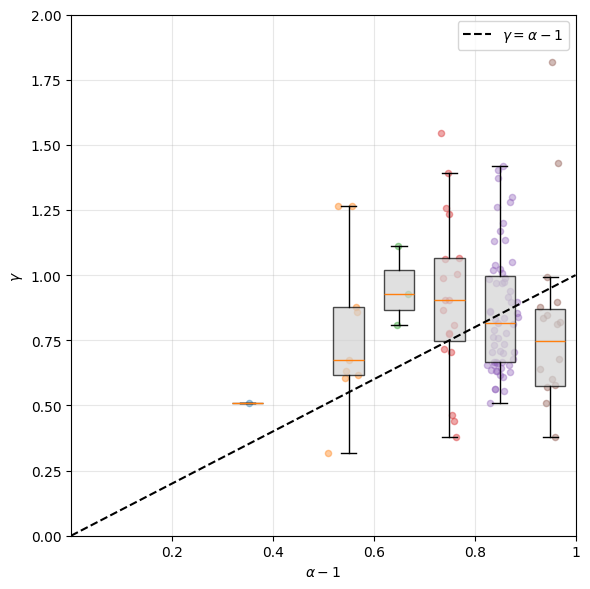

In [9]:
df        = pd.DataFrame({'alpha - 1' : alpha_estimate, 'gamma' : gamma_estimate})
bins      = np.linspace(0, 1, 11)
df['bin'] = pd.cut(df['alpha - 1'], bins = bins)
#y         = df.groupby('bin', observed = True)['gamma']
#x         = df['bin'].cat.categories.mid

bin_intervals = df['bin'].cat.categories
bin_mids      = bin_intervals.mid

plt.figure(figsize = (6, 6))

# Draw boxplots bin-by-bin
for i, interval in enumerate(bin_intervals):
    gamma_vals = df.loc[df['bin'] == interval, 'gamma'].dropna()
    
    if len(gamma_vals) == 0:
        continue
    
    # Boxplot at the bin midpoint
    plt.boxplot(gamma_vals, positions = [bin_mids[i]], widths = 0.06, patch_artist = True, showfliers = False,
                boxprops = dict(facecolor = 'lightgray', alpha = 0.7))
    
    # Scatter (jittered)
    x_jitter = bin_mids[i] + 0.015 * np.random.randn(len(gamma_vals))
    plt.scatter(x_jitter, gamma_vals, alpha = 0.4, s = 20)

# Theoretical line
plt.plot([0, 1], [0, 1], 'k--', label = r'$\gamma = \alpha - 1$')
plt.xticks(ticks = [0.2, 0.4, 0.6, 0.8, 1.0], labels = ['0.2', '0.4', '0.6', '0.8', '1'])
plt.xlabel(r'$\alpha - 1$')
plt.ylabel(r'$\gamma$')
plt.xlim(0, 1)
plt.ylim(0, 2)
plt.grid(alpha = 0.3)
plt.legend()

plt.tight_layout()

plt.savefig('alpha_gamma_power_100.pdf')
b2.put_file('alpha_gamma_power_100.pdf', 'figures')
b2.get_file('figures/alpha_gamma_power_100.pdf')

plt.show()

In [11]:
b2.get_file('test_data/alpha_gamma_half_df.csv')
alpha_gamma_half_df = pd.read_csv('alpha_gamma_half_df.csv')

In [12]:
alpha_estimate_half = alpha_gamma_half_df['alpha'].values - 1
gamma_estimate_half = alpha_gamma_half_df['gamma_nlls'].values

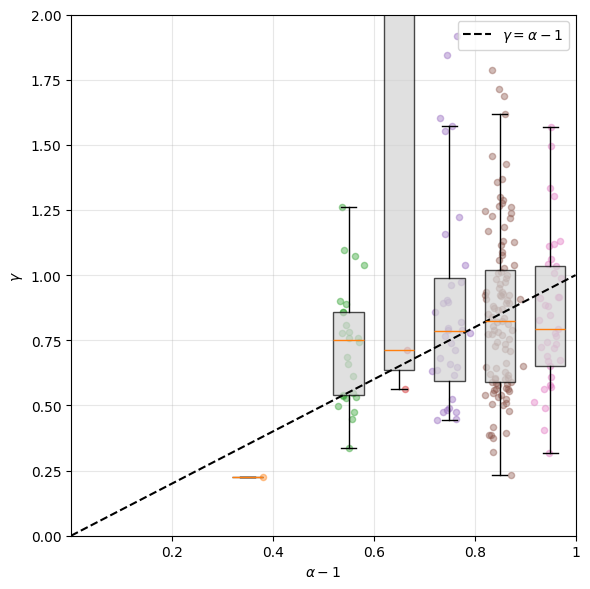

In [13]:
df        = pd.DataFrame({'alpha - 1' : alpha_estimate_half, 'gamma' : gamma_estimate_half})
bins      = np.linspace(0, 1, 11)
df['bin'] = pd.cut(df['alpha - 1'], bins = bins)
#y         = df.groupby('bin', observed = True)['gamma']
#x         = df['bin'].cat.categories.mid

bin_intervals = df['bin'].cat.categories
bin_mids      = bin_intervals.mid

plt.figure(figsize = (6, 6))

# Draw boxplots bin-by-bin
for i, interval in enumerate(bin_intervals):
    gamma_vals = df.loc[df['bin'] == interval, 'gamma'].dropna()
    
    if len(gamma_vals) == 0:
        continue
    
    # Boxplot at the bin midpoint
    plt.boxplot(gamma_vals, positions = [bin_mids[i]], widths = 0.06, patch_artist = True, showfliers = False,
                boxprops = dict(facecolor = 'lightgray', alpha = 0.7))
    
    # Scatter (jittered)
    x_jitter = bin_mids[i] + 0.015 * np.random.randn(len(gamma_vals))
    plt.scatter(x_jitter, gamma_vals, alpha = 0.4, s = 20)

# Theoretical line
plt.plot([0, 1], [0, 1], 'k--', label = r'$\gamma = \alpha - 1$')
plt.xticks(ticks = [0.2, 0.4, 0.6, 0.8, 1.0], labels = ['0.2', '0.4', '0.6', '0.8', '1'])
plt.xlabel(r'$\alpha - 1$')
plt.ylabel(r'$\gamma$')
plt.xlim(0, 1)
plt.ylim(0, 2)
plt.grid(alpha = 0.3)
plt.legend()

plt.tight_layout()

plt.savefig('alpha_gamma_power_100_half.pdf')
b2.put_file('alpha_gamma_power_100_half.pdf', 'figures')
b2.get_file('figures/alpha_gamma_power_100_half.pdf')

plt.show()

Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 45/45 [00:00<00:00, 84.11it/s]
/home/bmll/.conda/envs/py311-stable/lib/python3.11/site-packages/powerlaw/distributions.py:743: OptimizeWarning:

Initial guess is not within the specified bounds



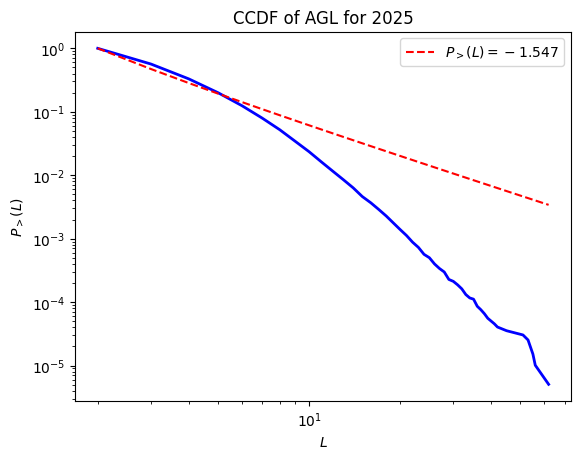

In [24]:
L = yearly_run_lengths_2025['AGL']['L']
# this list comprehension works by item for (sublist in run_lengths) for item in sublist
L = np.array(L)

fit = powerlaw.Fit(L, discrete = True)

alpha = fit.power_law.alpha
xmin  = fit.power_law.xmin

fig = fit.plot_ccdf(color = 'blue', linewidth = 2)
fit.power_law.plot_ccdf(color = 'red', linestyle = '--', ax = fig, label = rf'$P_{{>}}(L) = -{alpha - 1:.3f}$')
plt.xlabel(r'$L$')
plt.ylabel(r'$P_{>}(L)$')
plt.title('CCDF of AGL for 2025')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')

plt.savefig('AGL_ccdf_2025.pdf')
b2.put_file('AGL_ccdf_2025.pdf', 'figures')
b2.get_file('figures/AGL_ccdf_2025.pdf')

plt.show()